# Import packages

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import f1_score, recall_score, precision_score

# Define some constants

In [2]:
DEMOGRAPHICS_PATH = "./data/processed/demographics.csv"
RESPONDENTS_PATH = "./data/processed/all_respondents.csv"
SAVE_PLOT_PATH = "./plots/"
SAVE_PLOT = True

# Read in the processed data sets

In [3]:
demographics = pd.read_csv(DEMOGRAPHICS_PATH, parse_dates=["start_date", "end_date"], infer_datetime_format=True, dtype={"respondent_id": "object"})
all_respondents = pd.read_csv(RESPONDENTS_PATH, dtype={"respondent_id": "object"})

# Define some helper functions

In [4]:
def plot_accuracy_by_group(group_category, group_names, df_input=demographics, font_size=24):
    """Automatically create an boxplot to show the accuracy distribution by the group_category"""
    # determine the post-processing step based on group_category
    if group_category in ("highest_academic_degree_held", "current_position"):
        df_pivot = df_input[["respondent_id", "accuracy", group_category]]
        xticklabels = group_names
    else:
        df_pivot = df_input.melt(id_vars=["respondent_id", "accuracy"], 
                                 var_name=group_category, 
                                 value_vars=group_names).dropna().drop(columns="value")
        xticklabels = [name.replace("_", " ").capitalize() for name in group_names]
    # count the number of people within each subgroup
    count_by_group = df_pivot.value_counts(subset=group_category)
    # generate a summary table for the accuracy distribution
    summary_by_group = df_pivot.groupby(by=group_category).describe()
    
    # create the boxplot
    plt.figure(figsize=(12, 9))
    plot_by_group = sns.boxplot(data = df_pivot, x=group_category, y="accuracy", order=group_names)
    plot_by_group.set_xticklabels(xticklabels)
    plot_by_group.set_xlabel(group_category.replace("_", " ").capitalize(), fontsize=24)
    plot_by_group.set_ylabel("Accuracy", fontsize=font_size)
    plot_by_group.tick_params(labelsize=font_size)
    
    # annotate the number of people within each subgroup
    x_bottom, _ = plot_by_group.get_xlim()
    _, y_top = plot_by_group.get_ylim()
    
    plot_by_group.annotate("# of\npeople", xy=(x_bottom, y_top), 
                           ha="right", va="bottom", fontsize=font_size, color="black")
    
    for index, name in enumerate(group_names):
        plot_by_group.annotate(str(count_by_group.loc[name]), xy=(index, y_top), 
                               ha="center", va="bottom", fontsize=24, color="black")
        
    return summary_by_group, plot_by_group


def plot_descriptor_usage(which, df_input, num_compounds=5, font_size=15):
    """A function to create the usage plot."""
    # determine whether to plot the top or bottom 5 compounds in terms of classification accuracy
    if which == "top":
        compound_descriptors = (
            descriptor_usage_ranked.head(n=num_compounds).apply(np.sum, axis=0) / (53 * num_compounds) * 100
        ).sort_values(ascending=False)
        title = "Descriptor Usage of {} Most Accurate Compounds".format(num_compounds)
    elif which == "bottom":
        compound_descriptors = (
            descriptor_usage_ranked.tail(n=num_compounds).apply(np.sum, axis=0) / (53 * num_compounds) * 100
        ).sort_values(ascending=False)
        title = "Descriptor Usage of {} Least Accurate Compounds".format(num_compounds)
    else:
        raise KeyError('Invalid input: please use either "top" or "bottom"')
    
    # create the plot
    plt.figure(figsize=(8, 6))
    compound_descriptor_plot = sns.barplot(x=compound_descriptors.index, y=compound_descriptors.values, color="#1f77b4",
                                           saturation=1)
    compound_descriptor_plot.set_ylabel("Relative frequency (%)", fontsize=font_size)
    compound_descriptor_plot.set_title(title, fontsize=15)
    _ = plt.setp(compound_descriptor_plot.get_xticklabels(), rotation=-45, ha="left", rotation_mode="anchor")
    compound_descriptor_plot.tick_params(labelsize=font_size)
    return compound_descriptor_plot


def eval_performance(df_input, pos_class, groupby_col="respondent_id"):
    """Create a dataframe that contains the human performance for a given binary classification task."""
    # binarize the label
    replace_dict = {"metal": 0, "insulator": 0, "mit": 0}
    replace_dict[pos_class] = 1
    df_eval = df_input.replace({"true_label": replace_dict, "predicted_label": replace_dict})
    
    # a convenient function to evaluate performance with the functions in score_funcs
    def custom_score(df_subgroup, score_funcs, avg_method="weighted"):
        true_values = df_subgroup["true_label"]
        predicted_value = df_subgroup["predicted_label"]
        return [score_func(true_values, predicted_value, average=avg_method) for score_func in score_funcs]
    
    # evaluate precision, recall, f1_score within each binary classification task
    df_eval_grouped = df_eval.groupby(by=[groupby_col]).apply(func=custom_score, score_funcs=[precision_score, recall_score, f1_score])
    df_performance = pd.DataFrame(df_eval_grouped.to_list(), columns=["precision_weighted", "recall_weighted", "f1_weighted"])
    df_performance[groupby_col] = df_eval_grouped.index
    df_performance = df_performance[[groupby_col, "precision_weighted", "recall_weighted", "f1_weighted"]]
    df_result = df_performance.melt(id_vars="respondent_id", 
                                    value_vars=["precision_weighted", "recall_weighted", "f1_weighted"], 
                                    var_name="metric_name", value_name="raw_metric")
    
    df_result["model_type"] = "Human"
    df_result["positive_class"] = pos_class.capitalize() if pos_class!= "mit" else pos_class.upper()
    return df_result[["model_type", "positive_class", "metric_name", "raw_metric"]]

## Demographics dataset

The `demographics` dataset, which as the name suggests, contains the demographics information of all 53 respondents who completed all the questions on the survey.

**Disclaimer**: The demographic-related questions were designed to anonymize each individual response, as **no** names, emails or institution affiliations were collected. The 4 questions on demographics are about

1. Field of study
    * Materials Science
    * Physics
    * Chemistry
2. Highest academic degree held
    * BA/BS
    * MS
    * PhD
3. Research type
    * Experimental
    * Computational
    * Theoretical
4. Current position
    * Graduate student
    * Postdoc
    * Faculty
    * Staff scientist

In [5]:
demographics.head()

,respondent_id,accuracy,start_date,end_date,materials_science,chemistry,physics,highest_academic_degree_held,current_position,experimental,computational,theoretical
0,10991455189,0.277778,2019-09-13 13:11:00,2019-09-13 13:15:00,Materials Science,NaN,NaN,BA/BS,Graduate Student,NaN,Computational,Theoretical
1,10280657682,0.944444,2018-10-15 12:56:00,2018-10-15 13:03:00,Materials Science,NaN,NaN,PhD,Faculty,Experimental,NaN,NaN
2,10172361981,0.666667,2018-08-21 13:55:00,2018-08-21 14:17:00,Materials Science,NaN,Physics,PhD,Faculty,Experimental,NaN,NaN
3,10171054108,0.611111,2018-08-20 22:32:00,2018-08-20 22:50:00,Materials Science,NaN,NaN,PhD,Faculty,Experimental,NaN,NaN
4,10163866999,0.333333,2018-08-16 02:35:00,2018-08-16 02:41:00,Materials Science,NaN,NaN,MS,Graduate Student,NaN,Computational,NaN


In [6]:
demographics.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53 entries, 0 to 52
Data columns (total 12 columns):
 #   Column                        Non-Null Count  Dtype         
---  ------                        --------------  -----         
 0   respondent_id                 53 non-null     object        
 1   accuracy                      53 non-null     float64       
 2   start_date                    53 non-null     datetime64[ns]
 3   end_date                      53 non-null     datetime64[ns]
 4   materials_science             45 non-null     object        
 5   chemistry                     3 non-null      object        
 6   physics                       20 non-null     object        
 7   highest_academic_degree_held  53 non-null     object        
 8   current_position              53 non-null     object        
 9   experimental                  36 non-null     object        
 10  computational                 18 non-null     object        
 11  theoretical                   7 no

## All respondents dataset 

The `all_respondent` dataset contains the individual classification on the included 18 compounds, as well as the descriptors important to each respondent when classifying each compound.

In [7]:
all_respondents.head()

,respondent_id,formula,true_label,predicted_label,stoichiometry,crystal_structure,average_metal_oxygen_bond_distance,total_number_of_valence_electrons,d_electron_count,mass_density,mean_electronegativity_of_elements_in_formula,polarizability_of_the_compound,standard_deviation_of_average_ionic_radius_of_elements,crystal_field_splitting_energy,electronic_correlation,other_please_specify
0,10105286993,LaRuO3,metal,mit,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
1,10105286993,LaFeO3,insulator,mit,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
2,10105286993,LaNiO3,metal,mit,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
3,10105286993,CaFeO3,mit,insulator,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN
4,10105286993,ReO3,metal,insulator,NaN,"Crystal structure (e.g. perovskite, rock salt,...",NaN,Total number of valence electrons,d electron count,NaN,NaN,NaN,NaN,Crystal field splitting energy,Electronic correlation,NaN


In [8]:
all_respondents.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 954 entries, 0 to 953
Data columns (total 16 columns):
 #   Column                                                  Non-Null Count  Dtype 
---  ------                                                  --------------  ----- 
 0   respondent_id                                           954 non-null    object
 1   formula                                                 954 non-null    object
 2   true_label                                              954 non-null    object
 3   predicted_label                                         954 non-null    object
 4   stoichiometry                                           469 non-null    object
 5   crystal_structure                                       548 non-null    object
 6   average_metal_oxygen_bond_distance                      275 non-null    object
 7   total_number_of_valence_electrons                       432 non-null    object
 8   d_electron_count                                  

# Demographics analysis

There are 53 respondents in total.

In [9]:
demographics.shape[0]

53

We can quickly check the accuracy distribution of all 53 respondents.

Text(0.5, 0, 'Accuracy')

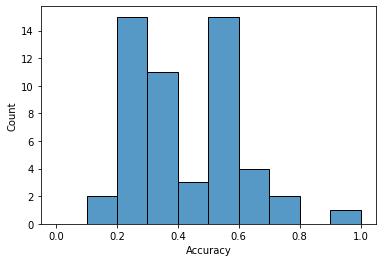

In [10]:
accuracy_dist = sns.histplot(data=demographics, x="accuracy", bins=np.linspace(0, 1, 11))
accuracy_dist.set_xlabel("Accuracy")

Here are some statistics for the accuracy.

In [11]:
demographics.accuracy.describe()

count    53.000000
mean      0.422432
std       0.164278
min       0.166667
25%       0.277778
50%       0.388889
75%       0.555556
max       0.944444
Name: accuracy, dtype: float64

## Accuracy by field of study

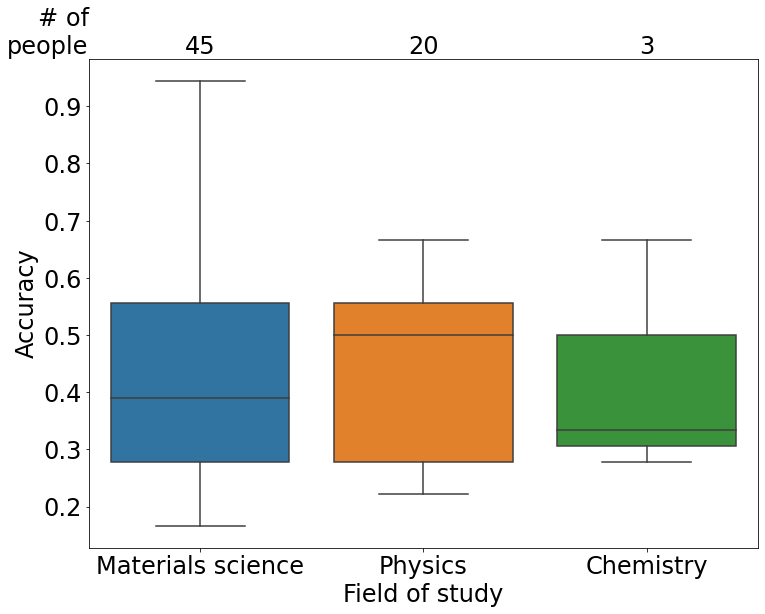

In [12]:
field_of_study_summary, field_of_study_plot= plot_accuracy_by_group("field_of_study", 
                                                                    ["materials_science", "physics", "chemistry"])

In [13]:
if SAVE_PLOT: field_of_study_plot.figure.savefig(SAVE_PLOT_PATH + "field_of_study.pdf", dpi=300, bbox_inches="tight")

In [14]:
field_of_study_summary

accuracy                                                    \
                     count      mean       std       min       25%       50%   
field_of_study                                                                 
chemistry              3.0  0.425926  0.210330  0.277778  0.305556  0.333333   
materials_science     45.0  0.428395  0.171488  0.166667  0.277778  0.388889   
physics               20.0  0.447222  0.145849  0.222222  0.277778  0.500000   

                                       
                        75%       max  
field_of_study                         
chemistry          0.500000  0.666667  
materials_science  0.555556  0.944444  
physics            0.555556  0.666667

## Accuracy by highest academic degree held

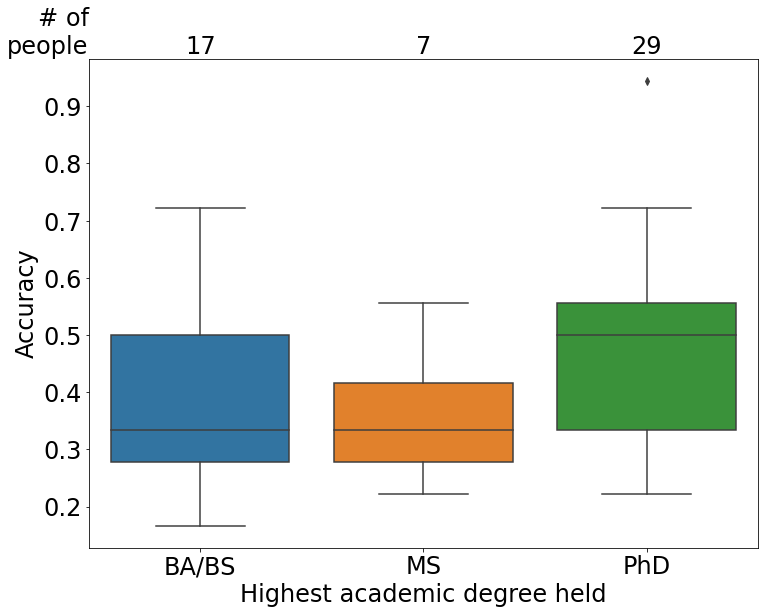

In [15]:
academic_degree_summary, academic_degree_plot= plot_accuracy_by_group("highest_academic_degree_held", 
                                                                      ["BA/BS", "MS", "PhD"])

In [16]:
if SAVE_PLOT: academic_degree_plot.figure.savefig(SAVE_PLOT_PATH + "academic_degree.pdf", dpi=300, bbox_inches="tight")

In [17]:
academic_degree_summary

accuracy                                          \
                                count      mean       std       min       25%   
highest_academic_degree_held                                                    
BA/BS                            17.0  0.372549  0.158071  0.166667  0.277778   
MS                                7.0  0.357143  0.115011  0.222222  0.277778   
PhD                              29.0  0.467433  0.168323  0.222222  0.333333   

                                                            
                                   50%       75%       max  
highest_academic_degree_held                                
BA/BS                         0.333333  0.500000  0.722222  
MS                            0.333333  0.416667  0.555556  
PhD                           0.500000  0.555556  0.944444

## Accuracy by research type

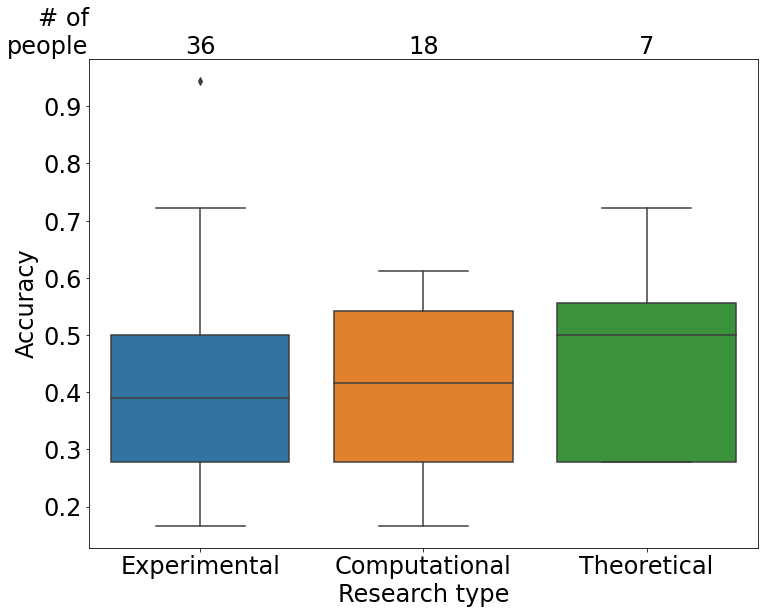

In [34]:
research_type_summary, research_type_plot= plot_accuracy_by_group("research_type", 
                                                                  ["experimental", "computational", "theoretical"])

In [35]:
if SAVE_PLOT: research_type_plot.figure.savefig(SAVE_PLOT_PATH + "research_type.pdf", dpi=300, bbox_inches="tight")

In [20]:
research_type_summary

accuracy                                          \
                         count      mean       std       min       25%   
primary_research_type                                                    
computational             18.0  0.404321  0.137153  0.166667  0.277778   
experimental              36.0  0.419753  0.168741  0.166667  0.277778   
theoretical                7.0  0.452381  0.176933  0.277778  0.277778   

                                                     
                            50%       75%       max  
primary_research_type                                
computational          0.416667  0.541667  0.611111  
experimental           0.388889  0.500000  0.944444  
theoretical            0.500000  0.555556  0.722222

## Accuracy by current position

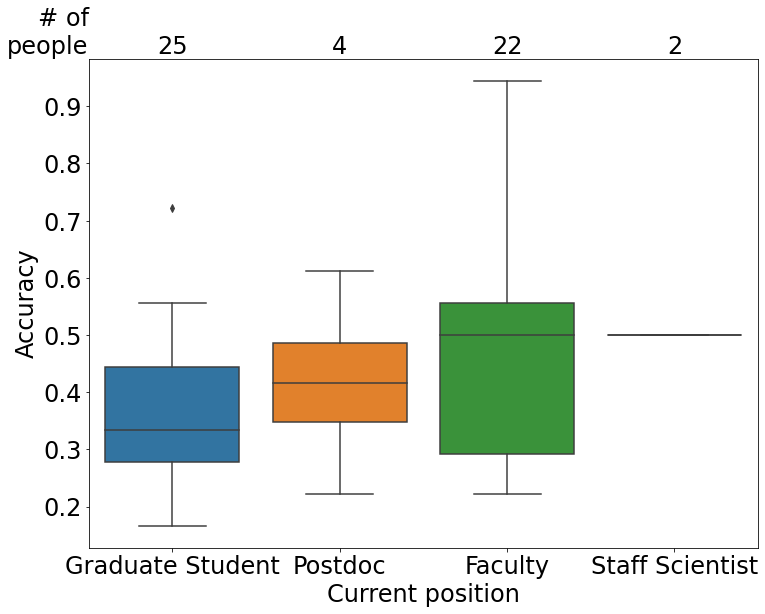

In [21]:
current_position_summary, current_position_plot = plot_accuracy_by_group("current_position", 
                                                                         ["Graduate Student", "Postdoc", "Faculty", "Staff Scientist"])

In [22]:
if SAVE_PLOT: current_position_plot.figure.savefig(SAVE_PLOT_PATH + "current_position.pdf", dpi=300, bbox_inches="tight")

In [23]:
current_position_summary

accuracy                                                    \
                    count      mean       std       min       25%       50%   
current_position                                                              
Faculty              22.0  0.479798  0.180262  0.222222  0.291667  0.500000   
Graduate Student     25.0  0.366667  0.141639  0.166667  0.277778  0.333333   
Postdoc               4.0  0.416667  0.160375  0.222222  0.347222  0.416667   
Staff Scientist       2.0  0.500000  0.000000  0.500000  0.500000  0.500000   

                                      
                       75%       max  
current_position                      
Faculty           0.555556  0.944444  
Graduate Student  0.444444  0.722222  
Postdoc           0.486111  0.611111  
Staff Scientist   0.500000  0.500000

# Descriptor usage analysis

Let's first find the classification accuracy for each compound.

In [24]:
accuracy_by_compound = all_respondents.groupby(by="formula").apply(func=lambda df: np.mean(df.true_label == df.predicted_label)).to_frame()
accuracy_by_compound = accuracy_by_compound.rename(columns={0: "accuracy"})
accuracy_by_compound = accuracy_by_compound.sort_values(by="accuracy", ascending=False)
accuracy_by_compound

,accuracy
formula,
Ca2RuO4,0.679245
BaVS3,0.660377
Ti2O3,0.584906
MoO3,0.566038
Cr2O3,0.547170
KVO3,0.547170
Sr2TiO4,0.547170
CaFeO3,0.528302
NbO2,0.509434


Then, we need to figure for each compound, how many times each of the 11 descriptors are used.

In [25]:
descriptor_usage = all_respondents.drop(columns=["respondent_id", "true_label", 
                                                 "predicted_label", "other_please_specify"]).groupby("formula").apply(
    func=lambda df: np.sum(~df.isna())
)
descriptor_usage

,formula,stoichiometry,crystal_structure,average_metal_oxygen_bond_distance,total_number_of_valence_electrons,d_electron_count,mass_density,mean_electronegativity_of_elements_in_formula,polarizability_of_the_compound,standard_deviation_of_average_ionic_radius_of_elements,crystal_field_splitting_energy,electronic_correlation
formula,,,,,,,,,,,,
Ag2BiO3,53,23,27,22,27,31,4,10,17,8,27,22
BaVS3,53,22,26,13,21,39,2,14,10,2,24,20
Ca2RuO4,53,23,33,15,24,37,1,9,10,3,28,29
CaFeO3,53,25,31,16,25,39,1,10,9,6,29,29
Cr2O3,53,23,29,16,20,38,1,8,7,2,22,19
KVO3,53,26,28,9,20,36,3,7,8,4,16,18
LaFeO3,53,26,36,17,29,40,3,8,12,3,32,29
LaNiO3,53,27,35,24,30,40,2,9,13,10,31,33
LaRuO3,53,27,37,26,26,40,1,8,9,4,31,33


We need to join the previous 2 dataframes together.

In [26]:
descriptor_usage_ranked = accuracy_by_compound.join(descriptor_usage).drop(columns=["accuracy", "formula"])
descriptor_usage_ranked = descriptor_usage_ranked.rename(columns={"stoichiometry": "Stoichiometry",
                                                                  "crystal_structure": "Crystal_structure", 
                                                                  "average_metal_oxygen_bond_distance": "Average_MO_distance",
                                                                  "total_number_of_valence_electrons": "Valence_electron", 
                                                                  "mass_density": "Mass_density", 
                                                                  "mean_electronegativity_of_elements_in_formula": "Mean_electronegativity",
                                                                  "polarizability_of_the_compound": "Polarizability",
                                                                  "standard_deviation_of_average_ionic_radius_of_elements": "Std_of_ionic_radius",
                                                                  "crystal_field_splitting_energy": "Crystal_field_splitting",
                                                                  "electronic_correlation": "Electronic_correlation"})
descriptor_usage_ranked

,Stoichiometry,Crystal_structure,Average_MO_distance,Valence_electron,d_electron_count,Mass_density,Mean_electronegativity,Polarizability,Std_of_ionic_radius,Crystal_field_splitting,Electronic_correlation
formula,,,,,,,,,,,
Ca2RuO4,23,33,15,24,37,1,9,10,3,28,29
BaVS3,22,26,13,21,39,2,14,10,2,24,20
Ti2O3,31,31,9,22,35,2,9,7,4,25,22
MoO3,27,26,15,30,36,4,7,9,4,17,15
Cr2O3,23,29,16,20,38,1,8,7,2,22,19
KVO3,26,28,9,20,36,3,7,8,4,16,18
Sr2TiO4,28,24,8,23,35,2,8,14,3,21,15
CaFeO3,25,31,16,25,39,1,10,9,6,29,29
NbO2,27,29,16,20,34,1,7,8,6,15,17


Plot the descriptor usage for the 5 compounds with the highest accuracy.

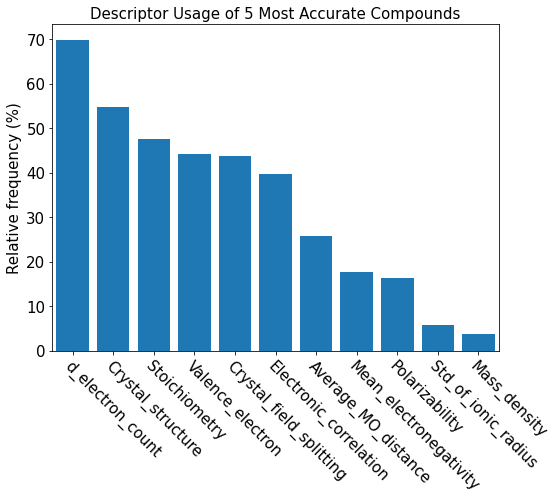

In [27]:
five_most_accurate_plot = plot_descriptor_usage("top", descriptor_usage_ranked)

In [28]:
if SAVE_PLOT: five_most_accurate_plot.figure.savefig(SAVE_PLOT_PATH + "five_most_accurate_plot.pdf", dpi=300, bbox_inches="tight")

Plot the descriptor usage for the 5 compounds with the lowest accuracy.

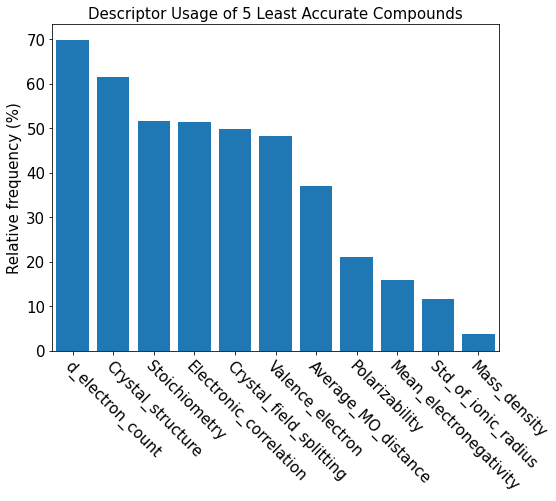

In [29]:
five_least_accurate_plot = plot_descriptor_usage("bottom", descriptor_usage_ranked)

In [30]:
if SAVE_PLOT: five_least_accurate_plot.figure.savefig(SAVE_PLOT_PATH + "five_least_accurate_plot.pdf", dpi=300, bbox_inches="tight")

# Evaluate human performance in terms of binary classification tasks

The 3 binary classification tasks are as follows.

1. Metal vs. non-Metal
2. Insulator vs. non-Insulator
3. MIT vs. non-MIT

In [31]:
# initialize an empty list to store the results
human_results = []
for positive_class in ["metal", "insulator", "mit"]:
    human_results.append(eval_performance(all_respondents, positive_class))
# concatenate the results into a single dataframe
df_human_results = pd.concat(human_results, ignore_index=True)

/Users/jasonrpw/PycharmProjects/mit_model_code/venv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [32]:
df_human_results

,model_type,positive_class,metric_name,raw_metric
0,Human,Metal,precision_weighted,0.511905
1,Human,Metal,precision_weighted,0.555556
2,Human,Metal,precision_weighted,0.375000
3,Human,Metal,precision_weighted,0.555556
4,Human,Metal,precision_weighted,0.625000
...,...,...,...,...
472,Human,MIT,f1_weighted,0.677066
473,Human,MIT,f1_weighted,0.630621
474,Human,MIT,f1_weighted,0.679167
475,Human,MIT,f1_weighted,0.945859


Save the results table.

In [33]:
df_human_results.to_csv("./data/processed/human_binary_classification_results.csv", index=False)